In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

### 0. Traning and Test data

In [2]:
geo_targeting = pd.read_csv('geo_targeting.csv')
geo_targeting.head()

,consumer_id,income,age,house_price,unemployment_rate,urban_dummy,revenue
0,1,5.000000,46.314644,50.097088,0.993050,1,348.98877
1,2,5.000000,48.982868,54.616592,0.993946,0,407.64410
2,3,5.000000,38.100559,58.686802,0.997256,1,549.99579
3,4,7.695054,43.880440,79.085518,0.981674,0,553.59064
4,5,66.245323,40.641262,662.831670,0.773164,1,644.58698


# Regularization & Lasso regression

In [8]:
from scipy import sparse
from sklearn import linear_model
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
#from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [9]:
# X variables to try for LASSO
#stores the dataset in a sparse matrix(no zero entries)
X = sparse.csc_matrix(geo_targeting[['income','age','house_price','urban_dummy','unemployment_rate']])

# Standarize features
scaler = StandardScaler(with_mean=False)
X_std = scaler.fit_transform(X)

# Y variable for LASSO
Y = geo_targeting['revenue']

In [10]:
#simple run of lasso
lasso = linear_model.Lasso(alpha = 0.2,max_iter = 5000)
lasso.fit(X_std, Y)


Lasso(alpha=0.2, max_iter=5000)

In [11]:
#print coefficient
print(lasso.intercept_,lasso.coef_/scaler.scale_)

464.2827933486207 [ 0.94807389  0.79353687  0.02902666 21.5900733  -0.        ]


In [12]:
# Compute paths
n_alpha = 250
alphas = np.logspace(-1, 3, n_alpha) #(start,stop, number of alphas)
coefs = []
for a in alphas:
    lasso = linear_model.Lasso(alpha=a,max_iter=5000)
    lasso.fit(X_std, Y)
    coefs.append(lasso.coef_/scaler.scale_)

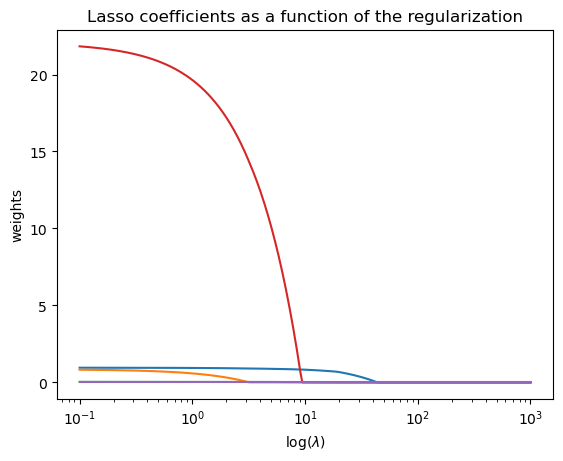

In [9]:
# Display results
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
plt.xlabel("$\log(\lambda)$")
plt.ylabel("weights")
plt.title("Lasso coefficients as a function of the regularization") 
plt.axis("tight")
plt.show()

### Cross Validation

In [14]:
# X variables to try for LASSO
X = sparse.csc_matrix(geo_targeting[['income','age','house_price','urban_dummy','unemployment_rate']])

# Standarize features
scaler = StandardScaler(with_mean=False)
X_std = scaler.fit_transform(X)

# Y variable for LASSO
Y = geo_targeting['revenue']

# We run CV Lasso
nfolds  = 10
lassocv = LassoCV(alphas = None, cv = nfolds, max_iter = 10000) #letting Lasso CV to choose alpha automatically
lassocv.fit(X_std,Y)

LassoCV(cv=10, max_iter=10000)

In [43]:
#1se rule 
#lassocv.mse_path_: each element is a list corresponding to each alpha. Each list contains the mse for each of the K folds. 
mean = np.mean(lassocv.mse_path_, axis=1) # computes the mean of the mse's for each list (for each alpha)
std_error = np.std(lassocv.mse_path_, axis=1)/np.sqrt(nfolds)
mean_min  = mean[lassocv.alphas_==lassocv.alpha_]
stde_min   = std_error[lassocv.alphas_==lassocv.alpha_]
alpha_1se = np.max(lassocv.alphas_[mean <= mean_min + stde_min])

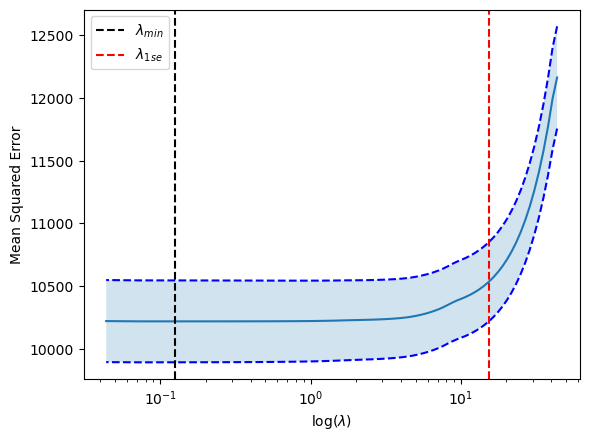

In [45]:
# simplest plot
plt.semilogx(lassocv.alphas_, np.mean(lassocv.mse_path_, axis=1))

# More elborate plot
# plot error lines showing +/- std. errors of the mse
mean = np.mean(lassocv.mse_path_, axis=1)
std_error = np.std(lassocv.mse_path_, axis=1)/np.sqrt(nfolds)

plt.semilogx(lassocv.alphas_, mean + std_error, "b--")
plt.semilogx(lassocv.alphas_, mean - std_error, "b--")
plt.fill_between(lassocv.alphas_, mean + std_error, mean - std_error, alpha=0.2)
plt.axvline(lassocv.alpha_, linestyle="--", color="black", label="$\lambda_{min}$")
plt.axvline(alpha_1se, linestyle="--", color="red", label="$\lambda_{1se}$")
plt.legend()
plt.xlabel("$\log(\lambda)$")
plt.ylabel("Mean Squared Error")
plt.show()

In [13]:
# getting the coefficients and picking those that are not zero
coefficients = np.append(lassocv.intercept_, lassocv.coef_/scaler.scale_) 
coeffnames = np.array(['(Intercept)', 'income','age','house_price','urban_dummy','unemployment_rate'])
coeffnames = coeffnames[coefficients != 0]
coeffvalues = coefficients[coefficients != 0]
# printing non-zero ones 
print(pd.DataFrame([coeffnames, coeffvalues]).T)

             0           1
0  (Intercept)  463.303913
1       income     0.94939
2          age    0.813673
3  house_price    0.029119
4  urban_dummy   21.773929
